In [1]:
import glob
import rasterio
from datetime import datetime
import numpy as np
import requests
import json
from collections import defaultdict
import geopandas as gpd
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from rasterio.transform import rowcol
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


# 1. Data Processing 

In [2]:
sm.__version__

'0.14.2'

In [ ]:
def bulkStationDownload(start_date,end_date, stations, api_key,include):
    # include arg could be 'days' or 'hours'
    cleanData = []
    
    for station_id in stations:
        try:
            url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{station_id}/{start_date}/{end_date}?unitGroup=us&include={include}&key={api_key}&contentType=json"
            response = requests.get(url)
            if response.status_code == 200:
                item = response.json()
                cleanData.append(item)
        except:
            print('got error for ',station_id)
    # Create a defaultdict to store dictionaries grouped by 'datetime'
    grouped_data = defaultdict(list)
    
    # Iterate through the list of dictionaries
    for item in cleanData:
        # Access datetime from each dictionary
        datetime = item['days'][0]['datetime']
        grouped_data[datetime].append(item)

    # Convert defaultdict to a regular dictionary if needed
    return(dict(grouped_data))

NameError: name 'lstRasters' is not defined

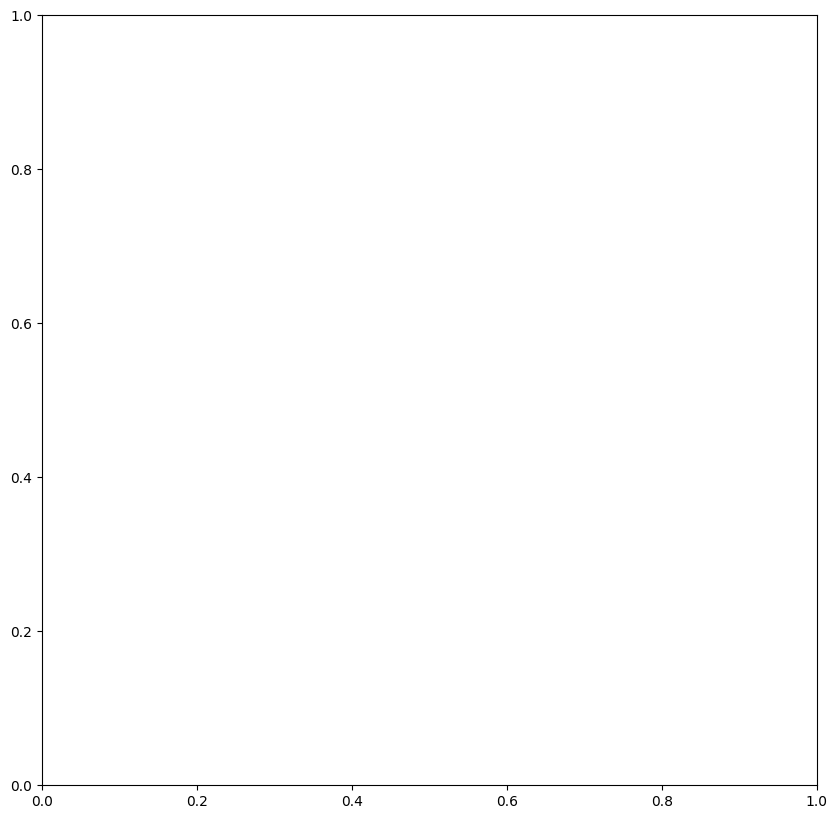

In [4]:

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Display the raster
raster_img = ax.imshow(lstRasters[0], extent=extent, cmap='gray', interpolation='none')

# Overlay the points
stations_gpd.plot(ax=ax, color='red', marker='o', markersize=5)

# Enhancements for better visualization
ax.set_title('Raster with Overlayed Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(raster_img, ax=ax, shrink=0.5, label='Raster Values')

plt.show()

In [5]:
# use np.mean 
# sci py method to avoid the loop 

In [6]:
def geographic_to_raster_indices(points_x, points_y, transform):
    """
    Convert geographic coordinates to raster indices.
    
    Parameters:
    - points_x: List or array of x coordinates (longitude/easting).
    - points_y: List or array of y coordinates (latitude/northing).
    - transform: Affine transform from the raster dataset (rasterio.transform.Affine).
    
    Returns:
    - rows, cols: Two arrays containing the row and column indices in the raster for each point.
    """
    # Convert each pair of points to row and column indices
    rows, cols = zip(*[rowcol(transform, x, y) for x, y in zip(points_x, points_y)])
    
    return np.array(rows), np.array(cols)

In [7]:
def extract_slices(raster_array, ar_points, size=21):
    # you should use an odd number
    half_size = size // 2
    slices = []
    
    for row, col in ar_points:
        # Calculate start and end indices for rows and columns
        row_start = max(0, row - half_size)
        row_end = min(raster_array.shape[0], row + half_size + 1)
        col_start = max(0, col - half_size)
        col_end = min(raster_array.shape[1], col + half_size + 1)
        
        # Extract the slice and append to the list
        slice = raster_array[row_start:row_end, col_start:col_end]
        
        # Handle cases where the slice is smaller than the desired size
        # This can happen if the point is near the edge of the raster
        # Optional: You can fill the missing parts with a specific value or ignore this part based on your requirements
        if slice.shape[0] != size or slice.shape[1] != size:
            # Example of filling the missing parts with zeros
            full_slice = np.zeros((size, size), dtype=raster_array.dtype)
            full_slice[:slice.shape[0], :slice.shape[1]] = slice
            slices.append(full_slice)
        else:
            slices.append(slice)
    
    return slices

In [8]:
def create_degree_masks(size=21, angle_width=10):
    # Determine the center of the square
    center = (size - 1) / 2
    # Create a meshgrid for x and y coordinates
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    # Calculate the angles in radians, adjust for orientation
    angles = np.rad2deg(np.arctan2((center - y), (x - center))) % 360
    # Correct the angle so 0 degrees points North
    angles = (angles +90 ) % 360

    masks = []
    for degree in range(360):
        # Calculate bounds for the wedge, centered at 'degree'
        half_width = angle_width / 2
        lower_bound = (degree - half_width) % 360
        upper_bound = (degree + half_width) % 360
        if lower_bound < upper_bound:
            mask = (angles >= lower_bound) & (angles <= upper_bound)
        else:  # Handle wrap-around at 360 to 0
            mask = (angles >= lower_bound) | (angles <= upper_bound)
        masks.append(np.flip(mask,axis=0))
    
    return masks

# Generate the masks with a customizable angle width (commented to avoid execution here)
# masks = create_degree_masks(size=21, angle_width=10)

In [9]:
def get_opposite_direction(angle):
    """
    Calculate the opposite direction given a wind direction in degrees.
    
    Parameters:
    - angle: The wind direction in degrees (0 to 359, where 0 is North).
    
    Returns:
    - The opposite direction in degrees.
    """
    if angle >= 0 and angle <= 179:
        return angle + 180
    elif angle >= 180 and angle <= 359:
        return angle - 180
    else:
        raise ValueError("Angle must be between 0 and 359 degrees.")

# Example usage
# opposite_angle = get_opposite_direction(90)  # This should return 270


In [10]:
# SHOW HOW IT WORKS 

# slice_size = 31
# slices = extract_slices(lstRasters[0], points_,size=slice_size)
# len(slices)
# # Generate the masks (commented to avoid execution here)
# masks = create_degree_masks(size = slice_size, angle_width=30)


# # example how to get the up/down wind values
# pointNumber  = 100
# this_slice   =  slices[pointNumber]
# up_winddir   = int(wind_direction[pointNumber])
# down_winddir = get_opposite_direction(up_winddir)

# up_wind_mask = masks[up_winddir]
# down_wind_maks =masks[down_winddir]

# up_wind_slice   = np.where(up_wind_mask, this_slice, np.nan)
# down_wind_slice = np.where(down_wind_maks, this_slice, np.nan)

# core_mean =np.nanmean(this_slice[12:18,12:18])
# up_wind_mean = np.nanmean(up_wind_slice)
# down_wind_mean = np.nanmean(down_wind_slice)

# core_mean,up_wind_mean,down_wind_mean

In [11]:
def columns_to_dict(df, key_col, value_col):
    return df.set_index(key_col)[value_col].to_dict()

In [12]:
def create_dict_from_two_lists(list_keys,list_vals):
    dict_output ={}
    for i in range(0,len(list_keys)):
        dict_output[list_keys[i]]=list_vals[i]
    return dict_output

In [13]:
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [14]:

# Specify the directory path and pattern
path = r"/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/*.TIF"  # Adjust this to your specific directory and file type


# List all files matching the pattern
file_list = glob.glob(path)

# (file_list)

shapeFilePath =r"/Users/artyom/Documents/work/UrbanHeat/WeatherStationData_2022_07_20_projected 1/WeatherStationData_2022_07_20_projected.shp"
stations_gpd = gpd.read_file(shapeFilePath)
crs_stations=stations_gpd.crs.to_string()


In [15]:
file_list

['/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20140807_20200911_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20210927_20211001_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20210826_20210901_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20190922_20200826_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20170612_20200903_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20220509_20220518_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20220914_20220922_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20200706_20200913_02_T1_ST_B10.TIF',
 '/Users/artyom/Documents/work/UrbanHeat/All_ST_Layers/LC08_L2SP_014032_20130601_20200912_02_T1_ST_B10.TIF',
 '/Users/artyom/Doc

In [16]:
lstRasters = []
lstDates = []
lstDatesString = []

for tif_file in file_list:
    with rasterio.open(tif_file) as src:
        # Do something with the dataset, e.g., print basic info or append to a list
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        profile = (src.profile)
        transform = src.transform
        # we need to convert this to F
        arST1 = ((src.read(1))*0.00341802) + 149.0 - 273.15
        # converts to F
        arST=(arST1 * 9/5) + 32
        lstRasters.append(arST)
        lstDates.append(datetime.strptime(tif_file[-34:-26], "%Y%m%d").date())
# Assuming `dates` is your list of datetime.date objects from the previous conversion
lstDatesString = [date.strftime('%Y-%m-%d') for date in lstDates]

# Now `date_strings_formatted` contains the dates in the 'YYYY-MM-DD' string format
len(lstDatesString)

19

In [17]:
len(lstDatesString)

19

In [18]:
lstAddresses = stations_gpd['address']

points_x_ = stations_gpd.geometry.x
points_y_ = stations_gpd.geometry.y

 # Convert geographic coordinates to raster indices
rows, cols = geographic_to_raster_indices(points_x_, points_y_, transform)
# print("Row indices:", rows)
# print("Column indices:", cols)

pointsIndecies = list(zip(rows,cols))
points_rows_cols = pointsIndecies.copy()


del rows, cols,points_x_,points_y_

In [19]:
profile['crs'],crs_stations

(CRS.from_epsg(32618), 'EPSG:32618')

In [20]:
# api_key_ = 'XJ9MLE3CE6DDL6VQRQYZPKQ27'

# dictDate_Data = {}
# for this_date in lstDatesString:
#     dictDate_Data[this_date]= bulkStationDownload(start_date=this_date, end_date=this_date, stations=lstStations, api_key= api_key_, include ='hours')

# file_path = 'hourlyData.pickle'

# # Step 3: Open a file in write-binary mode
# with open(file_path, 'wb') as file:
#     # Step 4: Use pickle.dump to write the dictionary to the file
#     pickle.dump(dictDate_Data, file)


In [21]:
# dictDate_Data.keys()

In [22]:
lst_df_n =[]
for k in dictDate_Data.keys():
    b = dictDate_Data[k]
    for eachStation in b[k]:
        address = eachStation['address']
        day_date =eachStation['days'][0]['datetime']
        # df_n is the dataframe for each day each station
        df_n = pd.DataFrame(eachStation['days'][0]['hours'])
        df_n['address_station'] = address
        df_n['day_date'] = day_date
        lst_df_n.append(df_n)

NameError: name 'dictDate_Data' is not defined

In [23]:
df = pd.concat(lst_df_n)

ValueError: No objects to concatenate

In [24]:
#len(df)

In [25]:
#len(df['day_date'].unique())

In [26]:
#df.to_csv('hourly_weather_data_for_lst_dates.csv')

In [35]:
df_hourly = pd.read_csv('/Users/artyom/Documents/work/UrbanHeat/Data/hourly_weather_data_for_lst_dates.csv')
df_hourly = df_hourly.loc[:, ~df_hourly.columns.str.contains('^Unnamed')]

/var/folders/lf/1r0cw2qs3pq870f2x7yb20w40000gn/T/ipykernel_68013/2469134473.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hourly = pd.read_csv('/Users/artyom/Documents/work/UrbanHeat/Data/hourly_weather_data_for_lst_dates.csv')


In [36]:
df_hourly.sample(2)

,datetime,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,solarradiation,solarenergy,uvindex,conditions,icon,stations,source,address_station,day_date,severerisk
66215,23:00:00,1497322800,81.8,84.9,64.49,68.6,0.000,0.0,NaN,0.0,...,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night,['remote'],obs,F6990,2017-06-12,NaN
149370,18:00:00,1630015200,92.9,105.0,57.03,75.5,0.031,100.0,0.0,0.0,...,196.5,0.7,2.0,"Rain, Partially cloudy",rain,['DEAN4'],obs,DEAN4,2021-08-26,NaN


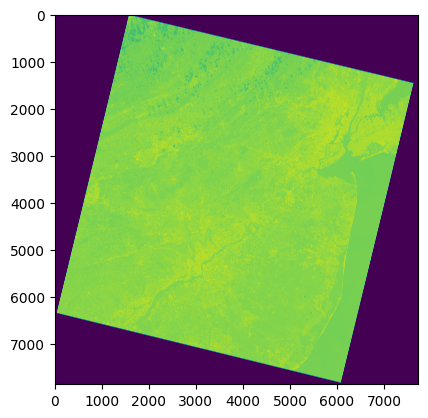

In [37]:
plt.imshow(lstRasters[0])

In [38]:
stations_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Field1      651 non-null    int64   
 1   datetime    651 non-null    object  
 2   datetimeEp  651 non-null    int64   
 3   tempmax     651 non-null    float64 
 4   tempmin     651 non-null    float64 
 5   temp        651 non-null    float64 
 6   feelslikem  651 non-null    float64 
 7   feelslik_1  651 non-null    float64 
 8   feelslike   651 non-null    float64 
 9   humidity    651 non-null    float64 
 10  precip      651 non-null    float64 
 11  snow        651 non-null    float64 
 12  windspeed   651 non-null    float64 
 13  winddir     651 non-null    float64 
 14  address     651 non-null    object  
 15  Lat         651 non-null    float64 
 16  Long        651 non-null    float64 
 17  geometry    651 non-null    geometry
dtypes: float64(13), geometry(1), int64(2), obj

In [39]:
# my_dict = {k: v for k, v in zip(df['column1'], df['column2'])}
dict_points ={k: v for k,v in zip(stations_gpd['address'],stations_gpd['geometry'])}

In [40]:
dict_xy_s ={}
for p in dict_points.items():
    dict_xy_s[p[0]] = [p[1].x,p[1].y]

In [41]:
df_hourly['X_Y_Metric'] = df_hourly['address_station'].map(dict_xy_s)

In [42]:
df_hourly.columns

Index(['datetime', 'datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew',
       'precip', 'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon',
       'stations', 'source', 'address_station', 'day_date', 'severerisk',
       'X_Y_Metric'],
      dtype='object')

In [43]:
df_hourly.sample()

,datetime,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,solarenergy,uvindex,conditions,icon,stations,source,address_station,day_date,severerisk,X_Y_Metric
66311,23:00:00,1497322800,79.4,79.4,72.23,69.7,0.0,0.0,NaN,0.0,...,0.0,0.0,Partially cloudy,partly-cloudy-night,['remote'],obs,E8943,2017-06-12,NaN,"[446992.38517734385, 4419483.971197358]"


In [44]:
df_noon = df_hourly.loc[(df_hourly['datetime'].isin(['12:00:00']))]
len(df_noon)

12369

In [45]:
profile['crs'],crs_stations

(CRS.from_epsg(32618), 'EPSG:32618')

In [46]:
df_noon.drop_duplicates(subset=['datetime', 'datetimeEpoch', 'temp', 'feelslike',
                                'humidity', 'dew', 'precip', 'precipprob', 'snow', 'snowdepth',
                                'preciptype', 'windgust', 'windspeed', 'winddir', 'pressure',
                                'visibility', 'cloudcover'], keep='first', inplace=True)

/var/folders/lf/1r0cw2qs3pq870f2x7yb20w40000gn/T/ipykernel_68013/4185123940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noon.drop_duplicates(subset=['datetime', 'datetimeEpoch', 'temp', 'feelslike',


In [47]:
df_noon

,datetime,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,solarenergy,uvindex,conditions,icon,stations,source,address_station,day_date,severerisk,X_Y_Metric
12,12:00:00,1370102400,67.6,67.6,90.50,64.7,0.000,0.0,NaN,NaN,...,3.5,10.0,Clear,clear-day,['remote'],obs,ALCN4,2013-06-01,NaN,"[546793.1496842903, 4356157.778658844]"
180,12:00:00,1370102400,87.7,89.2,45.90,64.3,0.000,0.0,NaN,NaN,...,3.5,10.0,Clear,clear-day,['KACY'],obs,KACY,2013-06-01,NaN,"[537857.9296011445, 4366807.866337107]"
204,12:00:00,1370102400,75.3,75.3,73.64,66.3,0.000,0.0,NaN,NaN,...,3.5,10.0,Clear,clear-day,['remote'],obs,D2738,2013-06-01,NaN,"[523040.26747632487, 4367226.929764999]"
420,12:00:00,1370102400,84.5,87.6,57.31,67.7,0.000,0.0,NaN,NaN,...,3.5,10.0,Partially cloudy,partly-cloudy-day,['remote'],obs,RDYD1,2013-06-01,NaN,"[450749.2798822352, 4378891.637570578]"
1068,12:00:00,1370102400,84.5,87.5,56.95,67.6,0.000,0.0,NaN,NaN,...,3.5,10.0,Partially cloudy,partly-cloudy-day,['remote'],obs,D3118,2013-06-01,NaN,"[406936.44354482664, 4391449.842388852]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296748,12:00:00,1690128000,76.0,76.0,51.64,56.9,0.020,100.0,0.0,0.0,...,3.0,8.0,Rain,rain,['remote'],obs,AVCP1,2023-07-23,10.0,"[444635.76639803, 4569984.594498139]"
296772,12:00:00,1690128000,74.9,74.9,51.82,56.0,0.000,0.0,0.0,0.0,...,2.4,7.0,Partially cloudy,partly-cloudy-day,['remote'],obs,DRHP1,2023-07-23,10.0,"[469116.2998720658, 4572193.007287515]"
296796,12:00:00,1690128000,74.9,74.9,49.83,54.9,0.031,100.0,0.0,0.0,...,2.9,8.0,Rain,rain,['remote'],obs,PA063,2023-07-23,10.0,"[454281.99877334246, 4573703.350762494]"
296820,12:00:00,1690128000,74.9,74.9,49.83,54.9,0.000,0.0,0.0,0.0,...,2.9,8.0,Clear,clear-day,['remote'],obs,MCWP1,2023-07-23,10.0,"[458512.4533282185, 4575754.02962291]"


In [48]:
size = 40
def core_size(size):
    if size >=10:
        radius =3
        center = size//2
        startRow = center-radius
        endRow = center + radius
        startCol =center-radius
        endCol = center + radius
    else:
        startRow=1
        endRow=-2
        startCol= 1
        endCol = -2
    return [startRow,endRow,startCol,endCol]

core_size(5)

[1, -2, 1, -2]

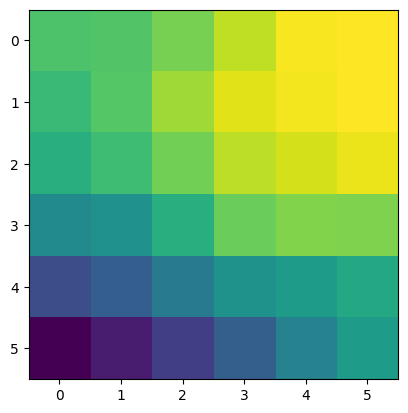

In [55]:
plt.imshow(st_slice[lstCoreIndecies[0]:lstCoreIndecies[1], lstCoreIndecies[2]:lstCoreIndecies[3]])
# np.nanmean(up_wind_slice)

In [56]:
# Set thresholds and parameters
temp_threshold = 45  # Minimum valid temperature in degree Celsius to filter out invalid data
slice_size = 41  # Size of the square area around a station to consider
angle_width_ = 28  # Width of the angle to define up-wind and down-wind directions
lstCoreIndecies = core_size(slice_size)
# Generate directional masks based on specified angle width and slice size
# Masks are used to filter areas of interest (up-wind and down-wind) relative to wind direction
masks = create_degree_masks(size=slice_size, angle_width=angle_width_)

lstVals = []  # Initialize a list to store results

# Loop through each raster dataset
for r in range(0, len(lstRasters)):
    # Filter DataFrame for the current date
    df_today = df_noon[df_noon['day_date'] == lstDatesString[r]]
    number_raster = r
    
    # Extract slices of interest around stations from the raster data
    slices = extract_slices(lstRasters[number_raster], points_rows_cols, size=slice_size)
    # Create a dictionary mapping station addresses to their respective slices
    dict_slices = create_dict_from_two_lists(lstAddresses, slices)
    
    # Loop through each row (station) in the filtered DataFrame for the current date
    for index, row in df_today.iterrows():
        st_address = row['address_station']  # Station address
        st_up_winddir = int(row['winddir'])  # Wind direction at the station
        st_windspeed = row['windspeed']  # Wind speed at the station
        st_slice_with_nan = dict_slices[st_address]  # Slice of interest for the station
        this_df = pd.DataFrame([row])  # Create a DataFrame for the current station's data
        
        # Check if the slice is valid (not empty and not filled with NaNs)
        if (np.nansum(st_slice_with_nan) < 1) | (st_slice_with_nan.size == 0):
            # If invalid, set default values for means
            this_df['core_mean'] = np.nan
            this_df['up_wind_mean'] = np.nan
            this_df['down_wind_mean'] = np.nan
        else:
            # Apply temperature threshold to filter invalid temperatures
            st_slice = np.where(st_slice_with_nan < temp_threshold, np.nan, st_slice_with_nan)
            
            # Adjust wind direction if necessary
            if st_up_winddir == 360:
                st_up_winddir = 0
            # Calculate the opposite direction for down-wind
            st_down_winddir = get_opposite_direction(st_up_winddir)
            
            # Apply masks to isolate up-wind and down-wind areas in the slice
            up_wind_mask = masks[st_up_winddir]
            down_wind_mask = masks[st_down_winddir]
            up_wind_slice = np.where(up_wind_mask, st_slice, np.nan)
            down_wind_slice = np.where(down_wind_mask, st_slice, np.nan)
            
            # Calculate mean temperatures for the core, up-wind, and down-wind areas
            this_df['core_mean'] = np.nanmean(st_slice[lstCoreIndecies[0]:lstCoreIndecies[1], lstCoreIndecies[2]:lstCoreIndecies[3]])
            this_df['up_wind_mean'] = np.nanmean(up_wind_slice)
            this_df['down_wind_mean'] = np.nanmean(down_wind_slice)
            
            # Append the station's DataFrame to the list
            lstVals.append(this_df)

# Concatenate all station DataFrames to form a final DataFrame
df_wind = pd.concat(lstVals)


In [77]:
lstVals

[       datetime  datetimeEpoch  temp  feelslike  humidity   dew  precip  \
 15636  12:00:00     1407427200  75.1       75.1     60.53  60.5     0.0   
 
        precipprob  snow  snowdepth  ...       icon    stations  source  \
 15636         0.0   NaN        NaN  ...  clear-day  ['remote']     obs   
 
        address_station    day_date  severerisk  \
 15636            ALCN4  2014-08-07         NaN   
 
                                    X_Y_Metric  core_mean  up_wind_mean  \
 15636  [546793.1496842903, 4356157.778658844]  79.151904    100.866366   
 
        down_wind_mean  
 15636       74.755671  
 
 [1 rows x 31 columns],
        datetime  datetimeEpoch  temp  feelslike  humidity   dew  precip  \
 15804  12:00:00     1407427200  78.7       78.7     47.54  57.1     0.0   
 
        precipprob  snow  snowdepth  ...       icon  stations  source  \
 15804         0.0   NaN        NaN  ...  clear-day  ['KACY']     obs   
 
        address_station    day_date  severerisk  \
 15804   

In [57]:
df_wind.sample(2)

,datetime,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,icon,stations,source,address_station,day_date,severerisk,X_Y_Metric,core_mean,up_wind_mean,down_wind_mean
257292,12:00:00,1658332800,90.9,96.4,49.94,69.7,0.0,0.0,0.0,0.0,...,clear-day,['TT136'],obs,TT136,2022-07-20,60.0,"[433090.64033372933, 4455569.07867587]",97.299027,92.792701,93.976820
118620,12:00:00,1599580800,80.0,80.0,58.16,63.9,0.0,0.0,0.0,0.0,...,partly-cloudy-day,['NJ13'],obs,NJ13,2020-09-08,NaN,"[548945.2155163708, 4480395.626363683]",96.403164,88.270946,92.935777


In [58]:
df_wind.temp.mean()

77.75787488620107

In [4]:
df_wind = pd.read_csv("/Users/artyom/Documents/work/UrbanHeat/Data/df_wind.csv") 


In [6]:
df_wind.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'datetime', 'datetimeEpoch', 'temp',
       'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow',
       'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy',
       'uvindex', 'conditions', 'icon', 'stations', 'source',
       'address_station', 'day_date', 'severerisk', 'X_Y_Metric', 'X_Metric',
       'Y_Metric', 'core_mean', 'up_wind_mean', 'down_wind_mean'],
      dtype='object')

<Axes: xlabel='core_mean', ylabel='Count'>

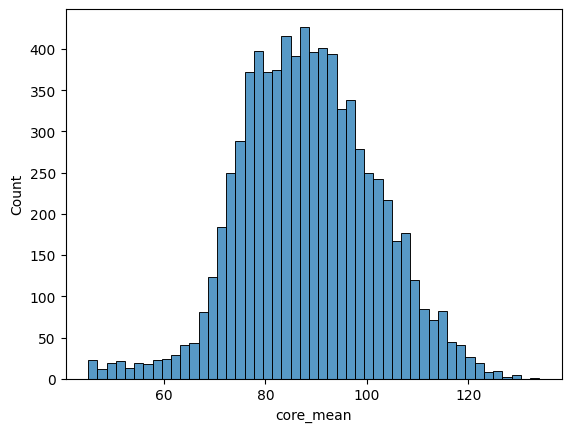

In [60]:
sns.histplot(data=df_wind,x='core_mean')

<Axes: xlabel='up_wind_mean', ylabel='temp'>

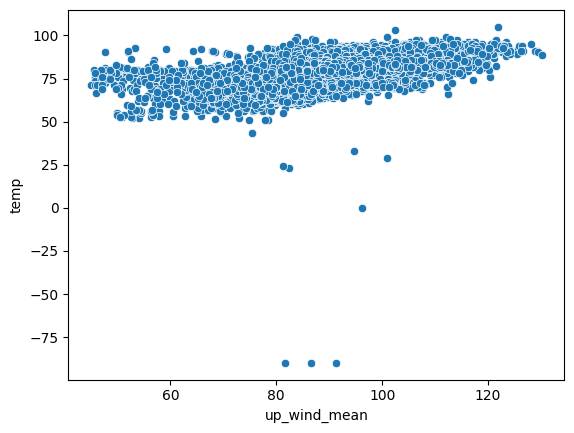

In [8]:
sns.scatterplot(data=df_wind,x='up_wind_mean',y='temp')

In [9]:
df_wind.shape

(7712, 35)

In [10]:
df_wind.temp.mean()

77.75264522821575

# 2. Models

In [11]:
df_wind = pd.read_csv("/Users/artyom/Documents/work/UrbanHeat/Data/df_wind.csv") 

dfModel = df_wind[['up_wind_mean', 'down_wind_mean','core_mean','temp','humidity','feelslike','precip','windspeed','solarradiation']].copy()

# dfModel = df_wind[['up_wind_mean', 'down_wind_mean','core_mean','temp','humidity','feelslike','precip','windspeed','solarradiation']]
dfModel.dropna(inplace= True)

dfModel.loc[:, 'wind_speed_up_wind_interaction'] = dfModel['windspeed'] * dfModel['up_wind_mean']


# Define the independent variables (X) and the dependent variable (y)
# X = dfModel[['up_wind_mean', 'down_wind_mean','core_mean','windspeed','wind_speed_up_wind_interaction']]
X = dfModel[['up_wind_mean', 'down_wind_mean','windspeed']]

y = dfModel['temp']


# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

# This code is for demonstration and won't run in this environment due to the commented out DataFrame loading.
# Ensure to have your DataFrame 'df' ready and uncomment related lines when running this in your local environment.

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     2016.
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:20:45   Log-Likelihood:                -25661.
No. Observations:                7653   AIC:                         5.133e+04
Df Residuals:                    7649   BIC:                         5.136e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             46.5535      0.638     72.

In [12]:
dfModel = df_wind[['up_wind_mean', 'down_wind_mean','core_mean','temp','humidity','feelslike','precip','windspeed','solarradiation']].copy()

# dfModel = df_wind[['up_wind_mean', 'down_wind_mean','core_mean','temp','humidity','feelslike','precip','windspeed','solarradiation']]
dfModel.dropna(inplace= True)

dfModel.loc[:, 'wind_speed_up_wind_interaction'] = dfModel['windspeed'] * dfModel['up_wind_mean']


# Define the independent variables (X) and the dependent variable (y)
# X = dfModel[['up_wind_mean', 'down_wind_mean','core_mean','windspeed','wind_speed_up_wind_interaction']]
X = dfModel[['up_wind_mean', 'down_wind_mean','windspeed']]

y = dfModel['temp']




# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

# This code is for demonstration and won't run in this environment due to the commented out DataFrame loading.
# Ensure to have your DataFrame 'df' ready and uncomment related lines when running this in your local environment.

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     2016.
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:20:46   Log-Likelihood:                -25661.
No. Observations:                7653   AIC:                         5.133e+04
Df Residuals:                    7649   BIC:                         5.136e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             46.5535      0.638     72.

In [13]:
df_wind

,Unnamed: 0.1,Unnamed: 0,datetime,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,...,source,address_station,day_date,severerisk,X_Y_Metric,X_Metric,Y_Metric,core_mean,up_wind_mean,down_wind_mean
0,1188,12,12:00:00,1370102400,85.9,88.3,51.75,66.1,0.000,0.0,...,obs,KILG,2013-06-01,NaN,"[449403.3116185275, 4392407.669136152]",449403.311619,4.392408e+06,75.840356,76.218535,74.769746
1,1908,12,12:00:00,1370102400,84.5,88.1,59.11,68.6,0.000,0.0,...,obs,E2237,2013-06-01,NaN,"[468801.3645834904, 4400684.096704739]",468801.364583,4.400684e+06,103.021818,106.543377,109.366548
2,1932,12,12:00:00,1370102400,83.7,87.4,61.24,69.0,0.000,0.0,...,obs,E0923,2013-06-01,NaN,"[495605.64733118593, 4400932.701835597]",495605.647331,4.400933e+06,91.492153,97.103335,94.015737
3,1980,12,12:00:00,1370102400,75.6,75.6,73.68,66.6,0.000,0.0,...,obs,BGLN4,2013-06-01,NaN,"[576183.7185731502, 4401587.10929382]",576183.718573,4.401587e+06,58.188675,58.441186,58.118405
4,2244,12,12:00:00,1370102400,85.2,88.5,56.35,67.9,0.000,0.0,...,obs,D0520,2013-06-01,NaN,"[413057.61137025576, 4403977.0439891415]",413057.611370,4.403977e+06,103.033781,96.277465,94.555035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,296748,12,12:00:00,1690128000,76.0,76.0,51.64,56.9,0.020,100.0,...,obs,AVCP1,2023-07-23,10.0,"[444635.76639803, 4569984.594498139]",444635.766398,4.569985e+06,78.689617,78.128462,78.710066
7708,296772,12,12:00:00,1690128000,74.9,74.9,51.82,56.0,0.000,0.0,...,obs,DRHP1,2023-07-23,10.0,"[469116.2998720658, 4572193.007287515]",469116.299872,4.572193e+06,71.973550,72.339408,72.182169
7709,296796,12,12:00:00,1690128000,74.9,74.9,49.83,54.9,0.031,100.0,...,obs,PA063,2023-07-23,10.0,"[454281.99877334246, 4573703.350762494]",454281.998773,4.573703e+06,NaN,48.539974,NaN
7710,296820,12,12:00:00,1690128000,74.9,74.9,49.83,54.9,0.000,0.0,...,obs,MCWP1,2023-07-23,10.0,"[458512.4533282185, 4575754.02962291]",458512.453328,4.575754e+06,82.057563,84.500593,79.515097


In [16]:
X_test

,const,up_wind_mean,down_wind_mean,windspeed
7301,1.0,106.253877,95.940028,0.9
4950,1.0,97.113562,94.775886,0.0
4339,1.0,83.444267,79.932233,9.6
830,1.0,112.336584,123.722776,0.0
2191,1.0,101.696415,97.115216,0.9
...,...,...,...,...
4592,1.0,73.074010,70.494860,9.2
7253,1.0,96.902404,95.980505,3.4
5508,1.0,95.159018,97.167276,0.9
6791,1.0,81.094101,76.406672,6.9


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = regressor.predict(X_test)

# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 46.80036684756098
R-squared: 0.44329433845268496


In [68]:
X_train

,const,up_wind_mean,down_wind_mean,windspeed
7318,1.0,91.712982,100.972078,0.7
3064,1.0,81.897820,87.418129,8.5
4042,1.0,96.507966,79.195484,2.0
3308,1.0,82.047922,77.369940,13.2
3243,1.0,77.910436,77.349418,9.6
...,...,...,...,...
5263,1.0,87.774443,90.663535,6.7
5427,1.0,84.405572,94.937517,3.1
862,1.0,90.908577,90.488927,2.7
7654,1.0,93.943015,86.980315,0.0


Feature Importance:
const: 0.0
up_wind_mean: 0.5060173430479487
down_wind_mean: 0.29114563585394393
windspeed: 0.20283702109810753


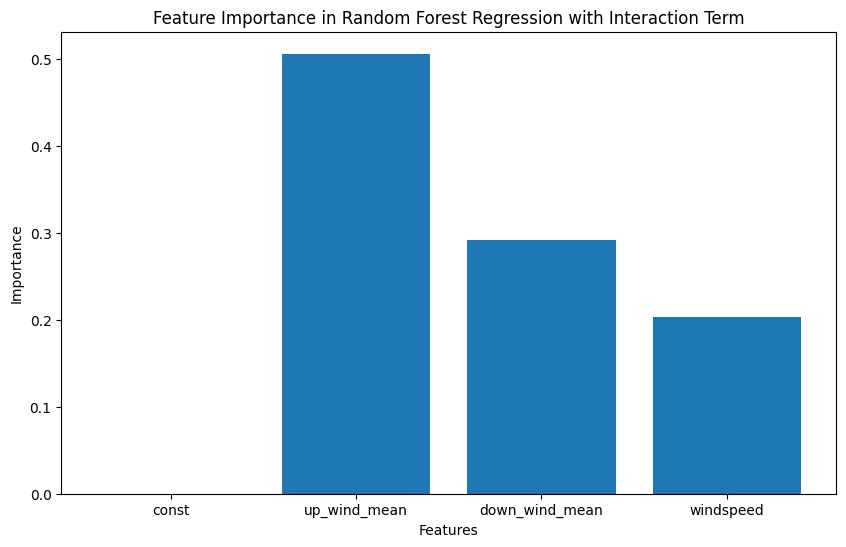

In [69]:
# Get feature importance
feature_importance = regressor.feature_importances_

# Print the feature importance
print("Feature Importance:")
for i, feat in enumerate(X.columns):
    print(f"{feat}: {feature_importance[i]}")

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Regression with Interaction Term')
plt.show()

After creating the initial model, we are tuning it to find the parameters that will give the best results on two selected metrics – R2 and MSE. To accomplish that we perform a Grid Search for all of the main Random Forest parameters, starting from the most essential – the number of trees.

In [70]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {"n_estimators":2**np.arange(14)} 

rf = RandomForestRegressor(random_state=42, warm_start=True)

#r2 = make_scorer(r2_score, greater_is_better=False)
#rmse = make_scorer(mean_squared_error, greater_is_better=False)
#custom_scorers = [("r2", r2), ("rmse", rmse)]


gs = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=make_scorer(mean_squared_error, greater_is_better=False),
                  cv=5, verbose=3)

In [14]:
param_grid

{'n_estimators': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
        2048, 4096, 8192])}

In [15]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ..................n_estimators=1;, score=-62.808 total time=   0.0s
[CV 2/5] END ..................n_estimators=1;, score=-97.589 total time=   0.0s
[CV 3/5] END ..................n_estimators=1;, score=-94.806 total time=   0.0s
[CV 4/5] END .................n_estimators=1;, score=-134.533 total time=   0.0s
[CV 5/5] END ..................n_estimators=1;, score=-70.915 total time=   0.0s
[CV 1/5] END ..................n_estimators=2;, score=-47.178 total time=   0.0s
[CV 2/5] END ..................n_estimators=2;, score=-55.565 total time=   0.0s
[CV 3/5] END ..................n_estimators=2;, score=-60.959 total time=   0.0s
[CV 4/5] END .................n_estimators=2;, score=-116.059 total time=   0.0s
[CV 5/5] END ..................n_estimators=2;, score=-49.856 total time=   0.0s
[CV 1/5] END ..................n_estimators=4;, score=-42.606 total time=   0.1s
[CV 2/5] END ..................n_estimators=4;, 

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'n_estimators': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
       2048, 4096, 8192])},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=3)

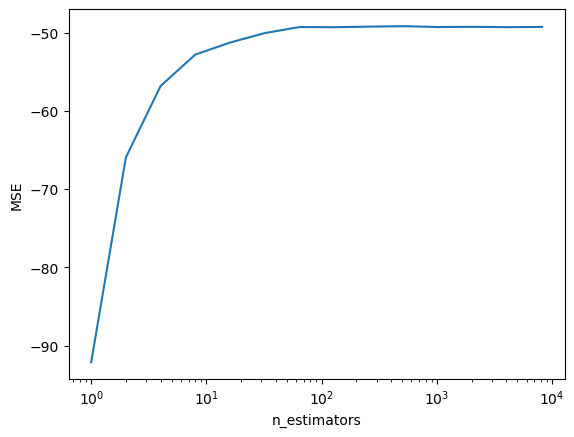

In [16]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.grid;

In [17]:
print('Best value of n:', param_grid["n_estimators"][np.argmax((gs.cv_results_['mean_test_score']))])

Best value of n: 512


In [18]:
param_grid = {"n_estimators":2**np.arange(12)} 

rf = RandomForestRegressor(random_state=42, warm_start=True)
gs = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=make_scorer(r2_score),
                  cv=5, verbose=3, n_jobs=-1)

In [19]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....................n_estimators=2;, score=0.383 total time=   0.0s
[CV 1/5] END ....................n_estimators=8;, score=0.491 total time=   0.1s
[CV 2/5] END ...................n_estimators=32;, score=0.478 total time=   0.4s
[CV 4/5] END ...................n_estimators=64;, score=0.260 total time=   0.8s
[CV 3/5] END ..................n_estimators=256;, score=0.482 total time=   3.1s
[CV 1/5] END .................n_estimators=1024;, score=0.525 total time=  12.6s


/Users/artyom/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END ....................n_estimators=1;, score=0.071 total time=   0.0s
[CV 4/5] END ....................n_estimators=4;, score=0.214 total time=   0.1s
[CV 2/5] END ...................n_estimators=16;, score=0.454 total time=   0.2s
[CV 5/5] END ...................n_estimators=32;, score=0.516 total time=   0.4s
[CV 2/5] END ..................n_estimators=128;, score=0.495 total time=   1.5s
[CV 5/5] END ..................n_estimators=256;, score=0.531 total time=   3.1s
[CV 3/5] END .................n_estimators=1024;, score=0.482 total time=  12.5s
[CV 1/5] END ....................n_estimators=1;, score=0.178 total time=   0.0s
[CV 5/5] END ....................n_estimators=2;, score=0.347 total time=   0.0s
[CV 2/5] END ....................n_estimators=4;, score=0.370 total time=   0.0s
[CV 5/5] END ....................n_estimators=8;, score=0.457 total time=   0.1s
[CV 3/5] END ...................n_estimators=32;, score=0.466 total time=   0.4s
[CV 1/5] END ...............

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
       2048])},
             scoring=make_scorer(r2_score), verbose=3)

In [47]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")
plt.grid;

NameError: name 'param_grid' is not defined

In [21]:
print('Best value of n:', param_grid["n_estimators"][np.argmax((gs.cv_results_['mean_test_score']))])

Best value of n: 512


Based on the graphs, we see that the performance of the model does not significantly improve after the 100 trees. Therefore, we are going to use this value for model tuning. For the final training, we will use 500 trees.

In [22]:
param_grid = {"max_features":2**np.arange(1, 9)}
#param_grid = {"max_features":np.arange(1, 20, 2)}

param_grid

{'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256])}

In [23]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42, warm_start=True)

gs = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=make_scorer(r2_score), verbose=3, n_jobs=-1)

In [24]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=42, warm_start=True),
             n_jobs=-1,
             param_grid={'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256])},
             scoring=make_scorer(r2_score), verbose=3)

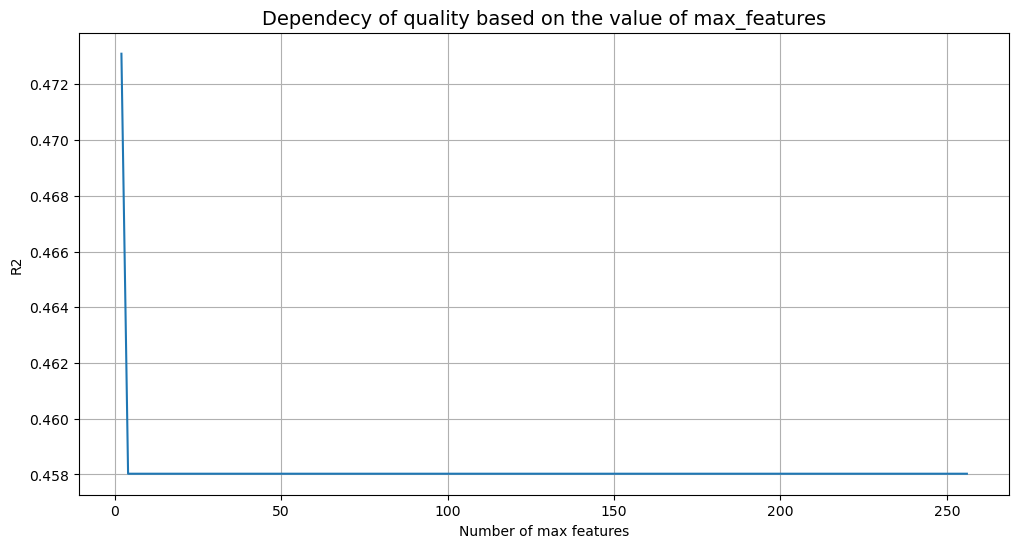

In [25]:
plt.figure(figsize=(12, 6))
plt.plot((param_grid["max_features"]), gs.cv_results_['mean_test_score'])
plt.xlabel("Number of max features")
plt.ylabel("R2")
plt.title("Dependecy of quality based on the value of max_features", fontsize = 14)
plt.grid();

In [26]:
print('Best value of max_features – ', param_grid["max_features"][np.argmax((gs.cv_results_['mean_test_score']))])

Best value of max_features –  2


We see that decision stumps (model with small amount of nodes) are the best fit for our data, as the perfomance of the model decrease as we increase the number of `max features`. (Results for MSE are the same.)

In [27]:
param_grid = { "min_samples_leaf": np.arange(1, 100, 5)
             }

In [28]:
regressor = RandomForestRegressor(n_estimators=100, max_features = 2, random_state=42)

gs = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=make_scorer(r2_score), verbose=3, n_jobs=-1)

In [29]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=RandomForestRegressor(max_features=2, random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             scoring=make_scorer(r2_score), verbose=3)

In [30]:
print('Best value of min_samples_leaf – ', param_grid["min_samples_leaf"][np.argmax((gs.cv_results_['mean_test_score']))])

Best value of min_samples_leaf –  11


In [31]:
param_grid = {"max_depth": np.arange(1, 100, 5), 
              "min_samples_split": np.arange(2, 100, 5)
             # "min_samples_leaf": np.arange(1, 100, 5)
             }

In [32]:
param_grid

{'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
        86, 91, 96]),
 'min_samples_split': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
        87, 92, 97])}

In [33]:
regressor = RandomForestRegressor(n_estimators=100, max_features = 2,min_samples_leaf = 11, random_state=42)

gs = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=make_scorer(r2_score), verbose=3, n_jobs=-1)

In [34]:
gs.fit(X_train, y_train)

In [36]:
print(gs.best_estimator_)
print(gs.best_score_)

RandomForestRegressor(max_depth=11, max_features=2, min_samples_leaf=11,
                      min_samples_split=67, random_state=42)
0.5098635772197613


In [71]:
# Initialize and train the Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=500,
                                  max_features = 10,
                                  min_samples_leaf=11,
                                  max_depth=10,
                                  min_samples_split=67,
                                  random_state=42)
regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = regressor.predict(X_test)

# Evaluate the regressor
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)


print(f"Mean Squared Error: {mse_new}, better than initial by {round(abs(mse_new - mse)/mse * 100,2)}%")
print(f"R-squared: {r2_new},better than initial by {round(abs(r2_new - r2)/r2 * 100,2)}%")

Mean Squared Error: 43.308460339917275, better than initial by 7.46%
R-squared: 0.48483170777996143,better than initial by 9.37%


In [73]:
import pickle

with open('regressor_model.pkl', 'wb') as file:
    pickle.dump(regressor, file)

In [74]:
# Load the model from the pickle file
with open('regressor_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [75]:
loaded_model

RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=11,
                      min_samples_split=67, n_estimators=500, random_state=42)

In [76]:
X_test

,const,up_wind_mean,down_wind_mean,windspeed
7301,1.0,106.253877,95.940028,0.9
4950,1.0,97.113562,94.775886,0.0
4339,1.0,83.444267,79.932233,9.6
830,1.0,112.336584,123.722776,0.0
2191,1.0,101.696415,97.115216,0.9
...,...,...,...,...
4592,1.0,73.074010,70.494860,9.2
7253,1.0,96.902404,95.980505,3.4
5508,1.0,95.159018,97.167276,0.9
6791,1.0,81.094101,76.406672,6.9


After performing Grid Search we find that the best performing parameters for two selected metrics R2 and MSE are: `n = 500, max_depth=11, max_features=2, min_samples_leaf=11, 
min_samples_split=67)`. After fine-tuning the model the performance of the model improved by approximately 7% for each of the metrics compared to the initial model we have created. However, as we are also interested in achieving substantial feature importance, we can use `max_features = 10`, which will increase the feature importance of `up_wind_mean` by 15%, but also will lead to falling in scoring metrics by 1% for each of them.  

Feature Importance:
const: 0.0
up_wind_mean: 0.5818069932575157
down_wind_mean: 0.1892701211314468
windspeed: 0.22892288561103752


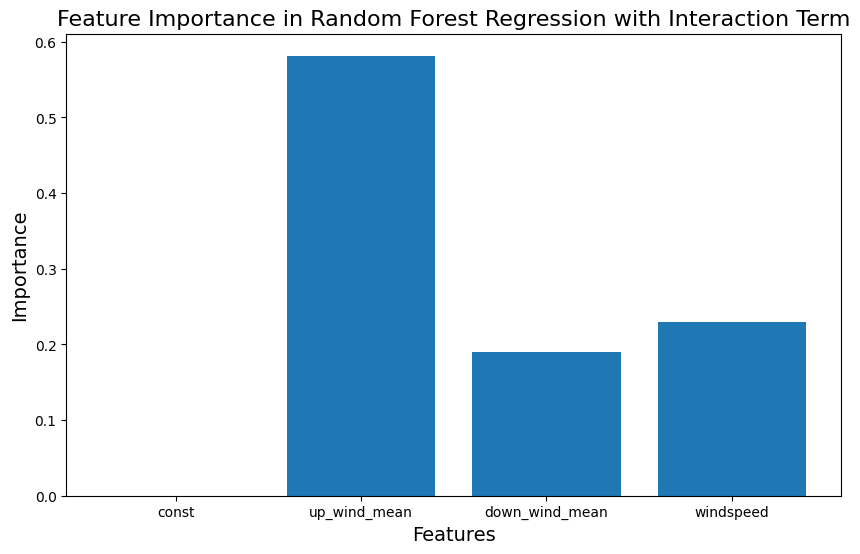

In [72]:
# Get feature importance
feature_importance = regressor.feature_importances_

# Print the feature importance
print("Feature Importance:")
for i, feat in enumerate(X.columns):
    print(f"{feat}: {feature_importance[i]}")

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.title('Feature Importance in Random Forest Regression with Interaction Term', size = 16)
plt.show()

### to create the curve for model performance

In [ ]:
lstSize_increments =[5,11,15,19,21,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81]

lstAngle_width = [10,12,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,35,38,41,45,50]


# lstModelOutput =[]

for m in lstSize_increments:
    print('size is: ',m)
    for n in lstAngle_width:
        # print('angle is: ',n)
        # Set thresholds and parameters
        temp_threshold = 5  # Minimum valid temperature in degree Celsius to filter out invalid data
        slice_size = m  # Size of the square area around a station to consider
        angle_width_ = n  # Width of the angle to define up-wind and down-wind directions
        lstCoreIndecies = core_size(slice_size)
        # Generate directional masks based on specified angle width and slice size
        # Masks are used to filter areas of interest (up-wind and down-wind) relative to wind direction
        masks = create_degree_masks(size=slice_size, angle_width=angle_width_)

        lstVals = []  # Initialize a list to store results

        # Loop through each raster dataset
        for r in range(0, len(lstRasters)):
            # Filter DataFrame for the current date
            df_today = df_noon[df_noon['day_date'] == lstDatesString[r]]
            number_raster = r

            # Extract slices of interest around stations from the raster data
            slices = extract_slices(lstRasters[number_raster], points_rows_cols, size=slice_size)
            # Create a dictionary mapping station addresses to their respective slices
            dict_slices = create_dict_from_two_lists(lstAddresses, slices)

            # Loop through each row (station) in the filtered DataFrame for the current date
            for index, row in df_today.iterrows():
                st_address = row['address_station']  # Station address
                st_up_winddir = int(row['winddir'])  # Wind direction at the station
                st_windspeed = row['windspeed']  # Wind speed at the station
                st_slice_with_nan = dict_slices[st_address]  # Slice of interest for the station
                this_df = pd.DataFrame([row])  # Create a DataFrame for the current station's data

                # Check if the slice is valid (not empty and not filled with NaNs)
                if (np.nansum(st_slice_with_nan) < 1) | (st_slice_with_nan.size == 0):
                    # If invalid, set default values for means
                    this_df['core_mean'] = np.nan
                    this_df['up_wind_mean'] = np.nan
                    this_df['down_wind_mean'] = np.nan
                else:
                    # Apply temperature threshold to filter invalid temperatures
                    st_slice = np.where(st_slice_with_nan < temp_threshold, np.nan, st_slice_with_nan)

                    # Adjust wind direction if necessary
                    if st_up_winddir == 360:
                        st_up_winddir = 0
                    # Calculate the opposite direction for down-wind
                    st_down_winddir = get_opposite_direction(st_up_winddir)

                    # Apply masks to isolate up-wind and down-wind areas in the slice
                    up_wind_mask = masks[st_up_winddir]
                    down_wind_mask = masks[st_down_winddir]
                    up_wind_slice = np.where(up_wind_mask, st_slice, np.nan)
                    down_wind_slice = np.where(down_wind_mask, st_slice, np.nan)

                    # Calculate mean temperatures for the core, up-wind, and down-wind areas
                    this_df['core_mean'] = np.nanmean(st_slice[lstCoreIndecies[0]:lstCoreIndecies[1], lstCoreIndecies[2]:lstCoreIndecies[3]])
                    this_df['up_wind_mean'] = np.nanmean(up_wind_slice)
                    this_df['down_wind_mean'] = np.nanmean(down_wind_slice)

                    # Append the station's DataFrame to the list
                    lstVals.append(this_df)

        # Concatenate all station DataFrames to form a final DataFrame
        df_wind = pd.concat(lstVals)

        dfModel = df_wind[['up_wind_mean', 'down_wind_mean','core_mean','temp','humidity','feelslike','precip','windspeed','solarradiation']].copy()

        # dfModel = df_wind[['up_wind_mean', 'down_wind_mean','core_mean','temp','humidity','feelslike','precip','windspeed','solarradiation']]
        dfModel.dropna(inplace= True)

        dfModel.loc[:, 'wind_speed_up_wind_interaction'] = dfModel['windspeed'] * dfModel['up_wind_mean']


        # Define the independent variables (X) and the dependent variable (y)
        X = dfModel[['up_wind_mean', 'down_wind_mean','core_mean','windspeed','wind_speed_up_wind_interaction']]
        y = dfModel['temp']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize and train the Random Forest Regressor
        regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        regressor.fit(X_train, y_train)

        # Predict on the testing set
        y_pred = regressor.predict(X_test)

        # Evaluate the regressor
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = regressor.feature_importances_ 
        
        lstModelOutput.append([m,n,r2,mse,feature_importance])

In [ ]:
feature_importanceappend

In [ ]:
dfModelOutput = pd.DataFrame(lstModelOutput,columns = ['Radius','Angle','R2','mse','feature_importance'])

In [ ]:
dfModelOutput[['up_wind_mean', 'down_wind_mean', 'core_mean', 'windspeed','wind_speed_up_wind_interaction']] = dfModelOutput['feature_importance'].apply(pd.Series)


In [ ]:
dfModelOutput.sample()

In [ ]:
dfModelOutput.columns

In [ ]:
dfModelOutput[['Radius', 'Angle', 'R2', 'up_wind_mean',
       'down_wind_mean',  'windspeed',
       ]]

# Model Output Graphs

In [52]:
dfModelOutput = pd.read_csv("/Users/artyom/Documents/work/UrbanHeat/ModelOutputs.csv")
dfModelOutput = dfModelOutput.loc[:, ~dfModelOutput.columns.str.contains('^Unnamed')]

In [53]:
dfModelOutput.sample(10)

,Radius,Angle,R2,mse,feature_importance,up_wind_mean,down_wind_mean,core_mean,windspeed,wind_speed_up_wind_interaction
496,53,38,0.469152,42.257217,[0.38539843 0.20984689 0.11276988 0.21462564 0...,0.385398,0.209847,0.112770,0.214626,0.077359
679,69,17,0.525034,33.099017,[0.37809521 0.20237695 0.13240299 0.20854921 0...,0.378095,0.202377,0.132403,0.208549,0.078576
185,29,23,0.558924,29.140749,[0.40299783 0.15960185 0.14225416 0.21265393 0...,0.402998,0.159602,0.142254,0.212654,0.082492
719,71,33,0.555587,29.465671,[0.38377219 0.19643353 0.13239335 0.20839231 0...,0.383772,0.196434,0.132393,0.208392,0.079009
180,29,18,0.439832,44.583202,[0.3786251 0.1502268 0.16186237 0.22572709 0...,0.378625,0.150227,0.161862,0.225727,0.083559
186,29,24,0.552208,29.584414,[0.41435637 0.16049464 0.13548263 0.2100793 0...,0.414356,0.160495,0.135483,0.210079,0.079587
581,61,19,0.595143,25.674963,[0.36174396 0.21507264 0.13484681 0.20924395 0...,0.361744,0.215073,0.134847,0.209244,0.079093
438,49,27,0.529149,32.500385,[0.41255039 0.1645466 0.1365591 0.209345 0...,0.412550,0.164547,0.136559,0.209345,0.076999
361,43,24,0.539171,29.528235,[0.40531549 0.17739818 0.1280977 0.20847301 0...,0.405315,0.177398,0.128098,0.208473,0.080716
681,69,19,0.540218,32.040838,[0.38059645 0.20738911 0.1280862 0.2079196 0...,0.380596,0.207389,0.128086,0.207920,0.076009


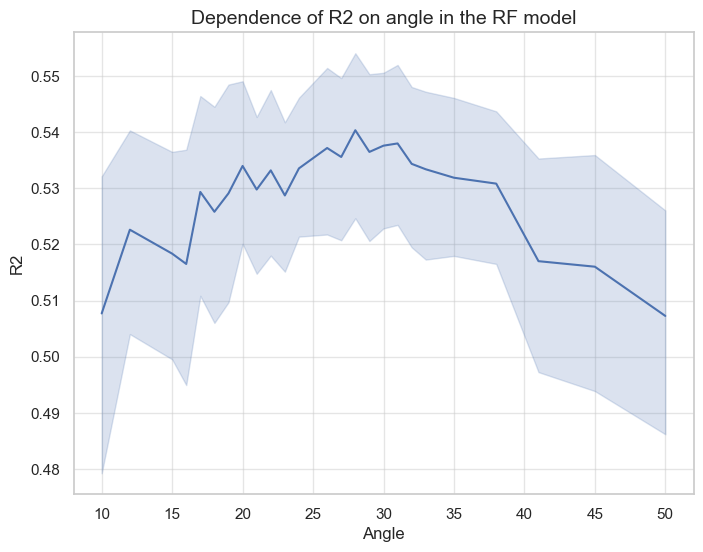

In [54]:
sns.set_theme(style='whitegrid')

plt.figure(figsize=(8, 6))

ax = sns.lineplot(data=dfModelOutput,x='Angle',y='R2')

plt.gca().xaxis.grid(alpha=0.5)
plt.gca().yaxis.grid(alpha=0.5)

ax.set_xlabel('Angle')
ax.set_ylabel('R2')

plt.title('Dependence of R2 on angle in the RF model', size = 14);

The graph shows the dependence of the R2 metric on wind angle. We see that the best performance is achieved with a wind angle in range of 25-30.

**Note:** the graph uses the data that was generated before the tuning of the RFR model and needs to be updated.

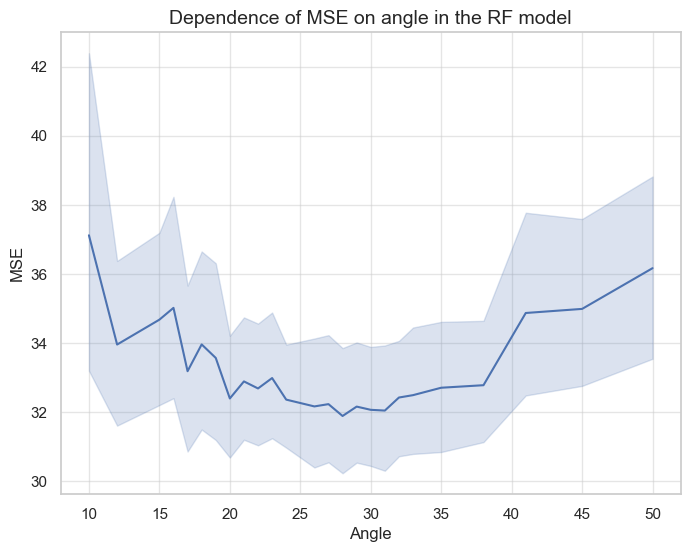

In [55]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 6))

plt.gca().xaxis.grid(alpha=0.5)
plt.gca().yaxis.grid(alpha=0.5)

ax = sns.lineplot(data=dfModelOutput,x='Angle',y='mse')


plt.title('Dependence of MSE on angle in the RF model', size = 14)
ax.set_xlabel('Angle')
ax.set_ylabel('MSE');

The graph shows the dependence of the MSE metric on wind angle. We see that the best performance is achieved with a wind angle at the value of 30.

**Note:** the graph uses the data that was generated before the tuning of the RFR model and needs to be updated.

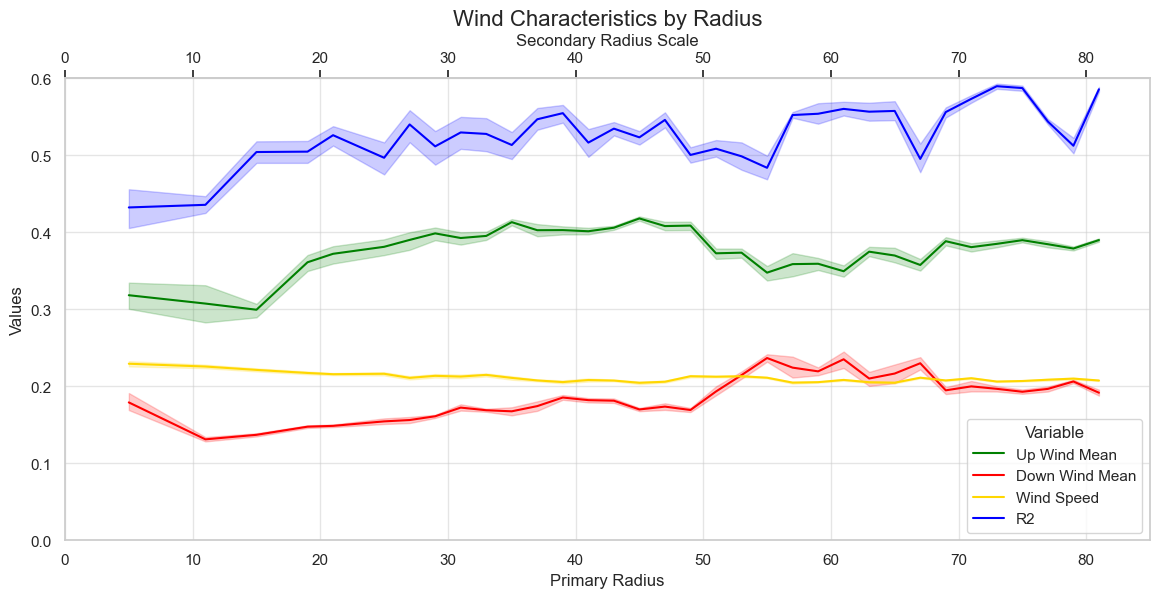

In [158]:
sns.set_theme(style='whitegrid')

plt.figure(figsize=(14, 6))  # For example, 10 inches by 6 inches

# Assuming dfModelOutput is your DataFrame and already defined

# Creating the primary axis plot
ax = sns.lineplot(data=dfModelOutput, x='Radius', y='up_wind_mean', color='green', label='Up Wind Mean')
sns.lineplot(data=dfModelOutput, x='Radius', y='down_wind_mean', color='red', label='Down Wind Mean')
sns.lineplot(data=dfModelOutput, x='Radius', y='windspeed', color='gold', label='Wind Speed')
sns.lineplot(data=dfModelOutput, x='Radius', y='R2', color='blue', label='R2')


plt.gca().xaxis.grid(alpha=0.5)
plt.gca().yaxis.grid(alpha=0.5)

ax.set_xlim(0, 85) 
ax.set_ylim(0, 0.6) 

# Customization for the primary axis
ax.set_title('Wind Characteristics by Radius', size = 16)
ax.set_xlabel('Primary Radius')
ax.set_ylabel('Values')
plt.legend(title='Variable')

# Add a secondary x-axis (assuming a direct correlation for illustration)
# This example simply renames it; adjust according to your specific needs
sec_ax = ax.secondary_xaxis('top')
sec_ax.set_xlabel('Secondary Radius Scale')
# Display the plot
plt.show();

The graph shows the dependence of the data features and the R2 metric on the radius used. We see a fluctuation in the values with a slight increase in the values as the radius increases.

**Note:** the graph uses the data that was generated before the tuning of the RFR model and needs to be updated. 

In [154]:
dfModelOutput.loc[dfModelOutput['R2']>0.54]

,Radius,Angle,R2,mse,feature_importance,up_wind_mean,down_wind_mean,core_mean,windspeed,wind_speed_up_wind_interaction
54,15,17,0.557700,29.497514,[0.31057897 0.1279645 0.26372781 0.21460872 0...,0.310579,0.127965,0.263728,0.214609,0.083120
55,15,18,0.562081,29.205361,[0.30272545 0.13556645 0.2655563 0.21357793 0...,0.302725,0.135566,0.265556,0.213578,0.082574
56,15,19,0.565880,28.952007,[0.30953908 0.13618129 0.25875564 0.21281564 0...,0.309539,0.136181,0.258756,0.212816,0.082708
96,19,38,0.546511,29.052934,[0.35865884 0.15291428 0.18689364 0.21583933 0...,0.358659,0.152914,0.186894,0.215839,0.085694
97,19,41,0.546871,29.029885,[0.37527668 0.15388315 0.17105091 0.21473696 0...,0.375277,0.153883,0.171051,0.214737,0.085052
...,...,...,...,...,...,...,...,...,...,...
845,81,35,0.583530,27.086074,[0.3831299 0.20061121 0.13352474 0.20665336 0...,0.383130,0.200611,0.133525,0.206653,0.076081
846,81,38,0.575574,27.603491,[0.37832119 0.20450584 0.13697218 0.20592761 0...,0.378321,0.204506,0.136972,0.205928,0.074273
847,81,41,0.595330,26.318603,[0.37838642 0.20577469 0.1370286 0.20498806 0...,0.378386,0.205775,0.137029,0.204988,0.073822
848,81,45,0.599326,26.058775,[0.38585703 0.20047669 0.13325498 0.20623889 0...,0.385857,0.200477,0.133255,0.206239,0.074172


In [56]:
#dfModelOutput.to_csv('ModelOutputs.csv')